# Example of Taylor series expansion of kinetic energy operator (KEO) for ammonia

Here, we use the following internal coordinates of ammonia molecule $\text{NH}_3$

1. $r_1$
2. $r_2$
3. $r_3$
4. $s_4 = (2\beta_{23}-\beta_{13}-\beta_{12})/\sqrt{6}$
5. $s_5 = (\beta_{13}-\beta_{12})/\sqrt{2}$
6. $\tau$

where $r_i\equiv\text{N-H}_i$, $\beta_{ij}$ are the $\text{H}_i\text{-C-H}_j$-valence-angle projections onto a plane perpendicular to the $z$-N trisector axis, and $\tau$ is an 'umbrella' angle $[-\pi,\pi]$.

We will build expansion of the KEO in terms of the following 1D functions of internal coordinates:

- $y_1=r_1-r_1^{(eq)}$
- $y_2=r_2-r_2^{(eq)}$
- $y_3=r_3-r_3^{(eq)}$
- $y_4=s_4$
- $y_5=s_5$
- $y_6=\cos(\rho)$,
  where $\rho=\tau+\pi/2$

In [1]:
import itertools
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp
from scipy import optimize

from vibrojet.jet_prim import acos
from vibrojet.keo import Gmat, com, pseudo
from vibrojet.potentials import nh3_POK
from vibrojet.taylor import deriv_list

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

config.update("jax_enable_x64", True)

Find equilibrium values of internal coordinates

In [2]:
@jax.jit
def poten(q):
    r1, r2, r3, s4, s5, tau = q
    rho = tau + np.pi / 2

    beta1 = jnp.sqrt(6) / 3 * s4 + 2 * np.pi / 3
    beta2 = -1 / jnp.sqrt(6) * s4 + 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3
    beta3 = -1 / jnp.sqrt(6) * s4 - 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3

    cosrho = jnp.cos(rho)
    sinrho = jnp.sin(rho)
    cosrho2 = cosrho * cosrho
    sinrho2 = sinrho * sinrho

    cosalpha2 = cosrho2 + sinrho2 * jnp.cos(beta2)
    cosalpha3 = cosrho2 + sinrho2 * jnp.cos(beta3)
    cosalpha1 = cosrho2 + sinrho2 * jnp.cos(beta2 + beta3)
    alpha1 = acos(cosalpha1)
    alpha2 = acos(cosalpha2)
    alpha3 = acos(cosalpha3)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v


vmin = optimize.minimize(poten, [1.1, 1.1, 1.1, 0.1, 0.1, 0.1])
q0 = vmin.x
v0 = vmin.fun

print("equilibrium coordinates:", q0)
print("min of the potential:", v0)

equilibrium coordinates: [1.01159999e+00 1.01159999e+00 1.01159999e+00 6.95820540e-09
 2.12731136e-09 3.85722364e-01]
min of the potential: 3.4875128536984075e-11


Define mapping from internal coordinates to Cartesian coordinates and to $y$-coordinates 

In [3]:
# masses of N, H1, H2, H3
masses = [14.00307400, 1.007825035, 1.007825035, 1.007825035]

# set reference tau to 0, i.e., planar molecular geometry
q0[-1] = 0

# internal-to-Cartesian coordinate transformation


@com(masses)
def internal_to_cartesian(internal_coords):
    r1, r2, r3, s4, s5, tau = internal_coords
    rho = tau + np.pi / 2

    beta1 = jnp.sqrt(6) / 3 * s4 + 2 * np.pi / 3
    beta2 = -1 / jnp.sqrt(6) * s4 + 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3
    beta3 = -1 / jnp.sqrt(6) * s4 - 1 / jnp.sqrt(2) * s5 + 2 * np.pi / 3

    cos_rho = jnp.cos(rho)
    sin_rho = jnp.sin(rho)
    cos_beta2 = jnp.cos(beta2)
    cos_beta3 = jnp.cos(beta3)
    sin_beta2 = jnp.sin(beta2)
    sin_beta3 = jnp.sin(beta3)

    xyz = jnp.array(
        [
            [0.0, 0.0, 0.0],
            [r1 * sin_rho, 0.0, r1 * cos_rho],
            [r2 * sin_rho * cos_beta3, r2 * sin_rho * sin_beta3, r2 * cos_rho],
            [r3 * sin_rho * cos_beta2, -r3 * sin_rho * sin_beta2, r3 * cos_rho],
        ]
    )
    return xyz


# y-coordinates for expansion of KEO


def internal_to_y(q):
    r1, r2, r3, s4, s5, tau = q
    rho = tau + jnp.pi / 2
    y1 = r1 - q0[0]
    y2 = r2 - q0[1]
    y3 = r3 - q0[2]
    y4 = s4
    y5 = s5
    y6 = jnp.cos(rho)
    return jnp.array([y1, y2, y3, y4, y5, y6])


def y_to_internal(y):
    y1, y2, y3, y4, y5, y6 = y
    r1 = y1 + q0[0]
    r2 = y2 + q0[1]
    r3 = y3 + q0[2]
    s4 = y4
    s5 = y5
    rho = acos(y6)
    tau = rho - np.pi / 2
    return jnp.array([r1, r2, r3, s4, s5, tau])


y0 = internal_to_y(q0)

In [4]:
xyz = internal_to_cartesian(q0)
print("Reference values of internal coordinates:\n", q0)
print("Reference values of expansion y-coordinates:\n", y0)
print("Reference values of Cartesian coordinates:\n", xyz)

Reference values of internal coordinates:
 [1.01159999e+00 1.01159999e+00 1.01159999e+00 6.95820540e-09
 2.12731136e-09 0.00000000e+00]
Reference values of expansion y-coordinates:
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.95820540e-09
 2.12731136e-09 6.12323400e-17]
Reference values of Cartesian coordinates:
 [[-2.82137658e-10 -3.20630097e-10 -1.09994111e-17]
 [ 1.01159999e+00 -3.20630097e-10  5.09432235e-17]
 [-5.05799994e-01  8.76071296e-01  5.09432236e-17]
 [-5.05799994e-01 -8.76071291e-01  5.09432234e-17]]


Generate expansion power indices

In [5]:
max_order = 4  # max total expansion order
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(len(q0))])
    if sum(elem) <= max_order
]
print("max expansion order:", max_order)
print("number of expansion terms:", len(deriv_ind))

max expansion order: 4
number of expansion terms: 210


Generate expansion of KEO in terms of internal coordinates

In [6]:
# G-matrix 

gmat_file = f"nh3_gmat_beta_coefs_{max_order}.npz"
if os.path.exists(gmat_file):
    print(
        f"load G-matrix expansion coefs from file {gmat_file} (delete file to recompute coefs)"
    )
    data = np.load(gmat_file)
    gmat_coefs = data["coefs"]
else:
    gmat_coefs = deriv_list(
        lambda x: Gmat(x, masses, internal_to_cartesian), deriv_ind, q0, if_taylor=True
    )
    np.savez(gmat_file, coefs=gmat_coefs, ind=deriv_ind, q0=q0)

load G-matrix expansion coefs from file nh3_gmat_beta_coefs_4.npz (delete file to recompute coefs)


In [7]:
# Pseudopotential

pseudo_file = f"nh3_pseudo_beta_coefs_{max_order}.npz"
if os.path.exists(pseudo_file):
    print(
        f"load pseudopotential expansion coefs from file {pseudo_file} (delete file to recompute coefs)"
    )
    data = np.load(pseudo_file)
    pseudo_coefs = data["coefs"]
else:
    pseudo_coefs = deriv_list(
        lambda x: pseudo(x, masses, internal_to_cartesian), deriv_ind, q0, if_taylor=True
    )
    np.savez(pseudo_file, coefs=pseudo_coefs, ind=deriv_ind, q0=q0)

k= Traced<ShapedArray(int64[6])>with<DynamicJaxprTrace>
Time for d= 0 : 9.7 s
Time for d= 1 : 0.0 s
Time for d= 2 : 20.66 s
Time for d= 3 : 37.55 s
Time for d= 4 : 64.64 s


In [8]:
# G-matrix

gmat_file = f"nh3_gmat_beta_y_coefs_{max_order}.npz"
if os.path.exists(gmat_file):
    print(
        f"load G-matrix expansion coefs from file {gmat_file} (delete file to recompute coefs)"
    )
    data = np.load(gmat_file)
    gmat_y_coefs = data["coefs"]
else:
    gmat_y_coefs = deriv_list(
        lambda y: Gmat(y_to_internal(y), masses, internal_to_cartesian),
        deriv_ind,
        y0,
        if_taylor=True,
    )
    np.savez(gmat_file, coefs=gmat_y_coefs, ind=deriv_ind, q0=q0, y0=y0)

load G-matrix expansion coefs from file nh3_gmat_beta_y_coefs_4.npz (delete file to recompute coefs)


In [11]:
# Pseudopotential

pseudo_file = f"nh3_pseudo_beta_y_coefs_{max_order}.npz"
if os.path.exists(pseudo_file):
    print(
        f"load pseudopotential expansion coefs from file {pseudo_file} (delete file to recompute coefs)"
    )
    data = np.load(pseudo_file)
    pseudo_y_coefs = data["coefs"]
else:
    pseudo_y_coefs = deriv_list(
        lambda y: pseudo(y_to_internal(y), masses, internal_to_cartesian),
        deriv_ind,
        y0,
        if_taylor=True,
    )
    np.savez(pseudo_file, coefs=pseudo_y_coefs, ind=deriv_ind, q0=q0, y0=y0)

Time for d= 0 : 0.39 s
Time for d= 1 : 0.02 s
Time for d= 2 : 0.21 s
Time for d= 3 : 0.47 s
Time for d= 4 : 1.0 s


Plot 1D cuts for various elements of G-matrix

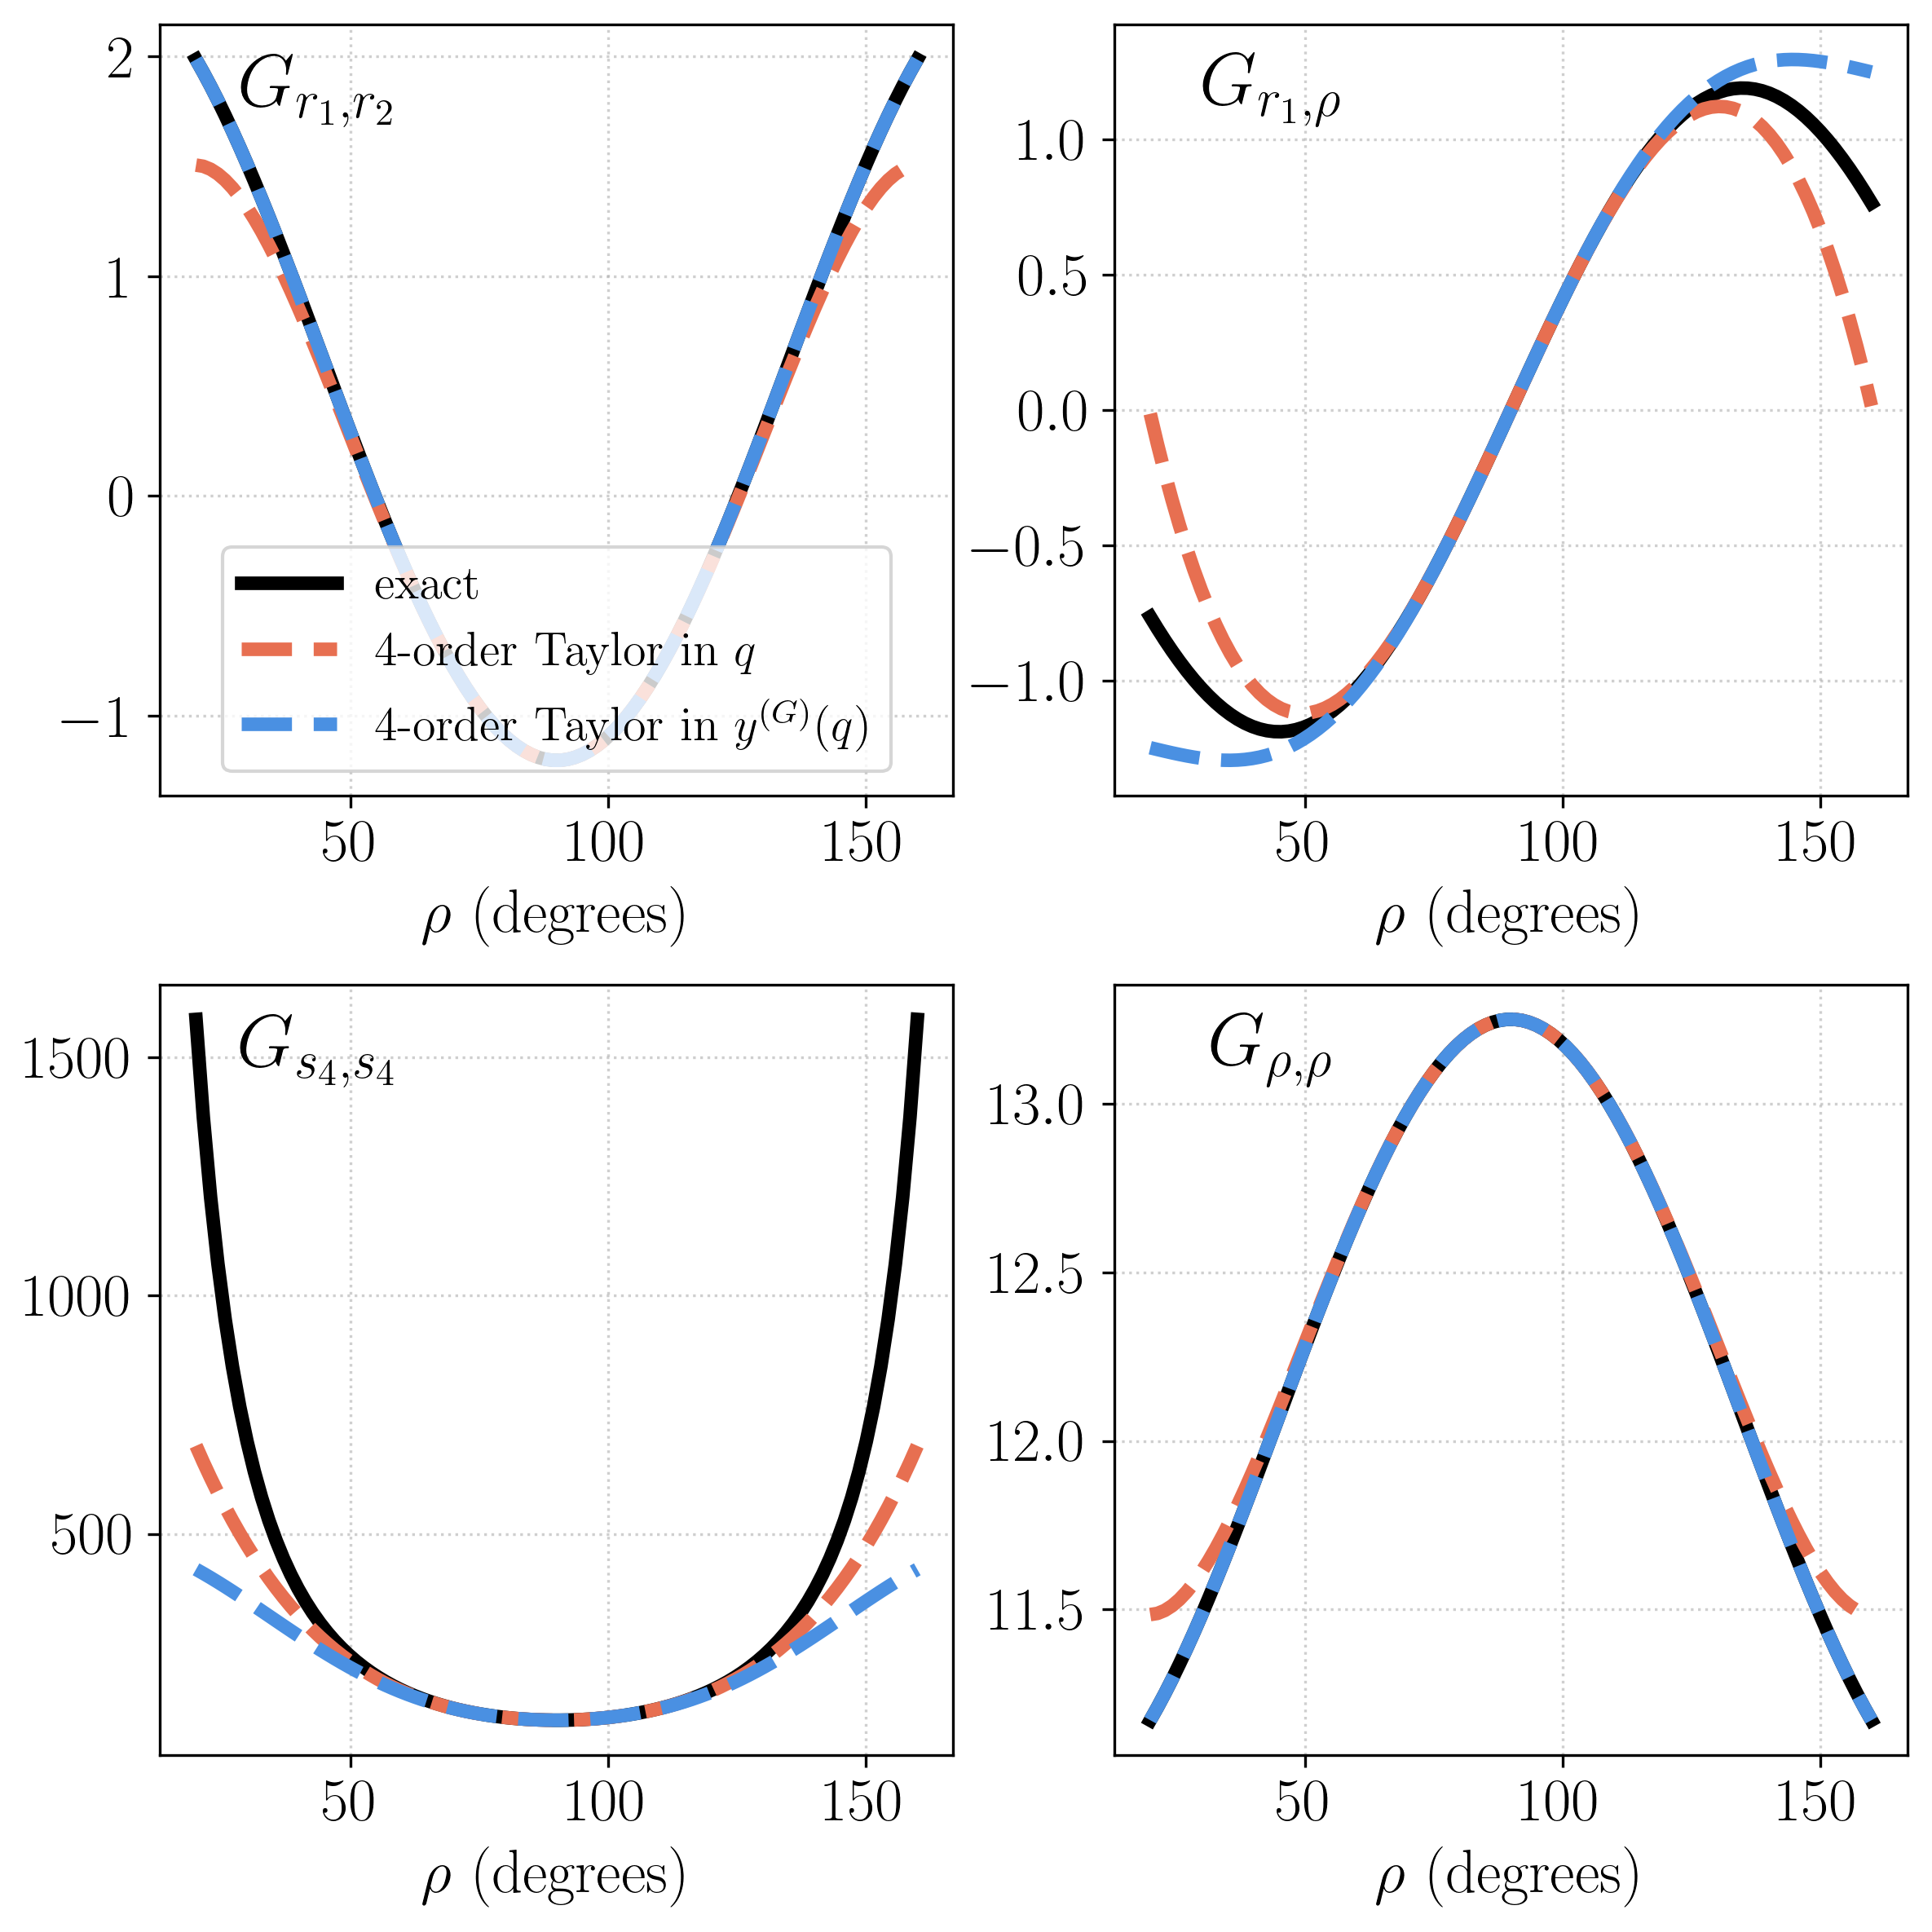

In [ ]:
gmat_taylor = jax.vmap(
    lambda x, x0, coefs, ind: coefs.swapaxes(0, 2)
    @ jnp.prod((x - x0)[None, :] ** jnp.array(ind), axis=-1),
    in_axes=(0, None, None, None),
)


tau = np.linspace(-70 * np.pi / 180, 70 * np.pi / 180, 100)
q = np.ones((len(tau), 6)) * np.array(q0)[None, :]
q[:, -1] = tau
y = jax.vmap(internal_to_y)(q)
tau_deg = tau * 180 / np.pi
rho_deg = tau_deg + 90

g_pts = jax.vmap(lambda x: Gmat(x, masses, internal_to_cartesian), in_axes=0)(q)
g_taylor = gmat_taylor(q, q0, gmat_coefs, deriv_ind)
g_in_y_taylor = gmat_taylor(y, y0, gmat_y_coefs, deriv_ind)


coo_lab = ("r_1", "r_2", "r_3", "s_4", "s_5", "\\rho")
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=300)

for ax, (icoo, jcoo) in zip(axes.flat, ((0, 1), (0, 5), (3, 3), (5, 5))):
    ax.plot(rho_deg, g_pts[:, icoo, jcoo], "-", linewidth=4, color="k", label="exact")
    ax.plot(
        rho_deg,
        g_taylor[:, icoo, jcoo],
        "--",
        linewidth=4,
        color="#e76f51",
        label=f"{max_order}-order Taylor in $q$",
    )
    ax.plot(
        rho_deg,
        g_in_y_taylor[:, icoo, jcoo],
        "--",
        linewidth=4,
        color="#4a90e2",
        label=f"{max_order}-order Taylor in " + "$y^{(G)}(q)$",
    )

    ax.text(
        0.2,
        0.96,
        "$G_{" + f"{coo_lab[icoo]},{coo_lab[jcoo]}" + "}$",
        fontsize=22,
        transform=ax.transAxes,
        ha="center",
        va="top",
    )

    ax.set_xlabel("$\\rho$ (degrees)", fontsize=18)
    ax.grid(True, linestyle=":", alpha=0.6)
    if (icoo, jcoo) == (0, 1):
        ax.legend(fontsize=14, loc="lower center")
    ax.tick_params(axis="both", labelsize=18)

plt.tight_layout()
fig.savefig(f"_nh3_keo_beta_{max_order}.pdf", format="pdf", bbox_inches="tight")